<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/PytorchAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.optim import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [5]:
class MarketData:
    @classmethod
    def initialize(cls):
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])


MarketData.initialize()

In [57]:
####################################################################################
############################Generate Data#############################################
####################################################################################
class CustomDataset(Dataset):
    def __init__(self, from_ind, to_ind, data_length, sampling_window):
        self.input, self.output = self.__generate_data(from_ind, to_ind, data_length, sampling_window)
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, index):
        #self.input = torch.tensor(self.input[index],dtype=torch.float32)
        #self.output = torch.tensor(self.self.output[index],dtype=torch.long)
        #self.input =self.input.to(device)
        #self.output =self.output.to(device)
        return torch.tensor(self.input[index], dtype=torch.float32), torch.tensor(self.output[index], dtype=torch.float32)
    
    def __generate_data(self, from_ind, to_ind, data_length, sampling_window):
        x = []
        y = []
        current_start = from_ind
        mmsc = MinMaxScaler(feature_range=(0,1), copy=True)
        while True:
            x.append(mmsc.fit_transform(np.array(MarketData.logclose[current_start : current_start + data_length]).reshape(-1,1)))
            y.append(mmsc.fit_transform(np.array(MarketData.logclose[current_start : current_start + data_length]).reshape(-1,1)))
            current_start += sampling_window
            if current_start >= to_ind:
                break
        return np.squeeze(x), np.squeeze(y)

dataset = CustomDataset(1000000, 1300000, 30, 100)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
train_set = torch.utils.data.Subset(dataset, range(train_size))
val_set = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))
train_dataloader = DataLoader(train_set, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape, y_batch.shape)

torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])
torch.Size([100, 30]) torch.Size([100, 30])


In [53]:
class AutoEncoder(nn.Module):
    def __init__(self, seq_len):
        super(AutoEncoder, self).__init__()
        self.dense1 = nn.Linear(seq_len, 2 * seq_len)
        self.norm1 = nn.LazyBatchNorm1d(2 * seq_len)
        self.dense2 = nn.Linear(2 * seq_len, int(0.5 * seq_len))
        self.norm2 = nn.LazyBatchNorm1d(int(0.5 * seq_len))
        self.dense3 = nn.Linear(int(0.5 * seq_len), 2 * seq_len)
        self.norm3 = nn.LazyBatchNorm1d(2 * seq_len)
        self.dense4 = nn.Linear(2 * seq_len, seq_len)

    def forward(self, input):
        output = F.relu(self.dense1(input))
        output = self.norm1(output)
        output = F.relu(self.dense2(output))
        output = self.norm2(output)
        output = F.relu(self.dense3(output))
        output = self.norm3(output)
        output = F.softmax(self.dense4(output))
        return output

model = AutoEncoder(30)
print(model)

AutoEncoder(
  (dense1): Linear(in_features=30, out_features=60, bias=True)
  (norm1): LazyBatchNorm1d(0, eps=60, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=60, out_features=15, bias=True)
  (norm2): LazyBatchNorm1d(0, eps=15, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=15, out_features=60, bias=True)
  (norm3): LazyBatchNorm1d(0, eps=60, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=60, out_features=30, bias=True)
)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

<ipython-input-53-1b17d2306ee6>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.dense4(output))


Epoch: 1/100, Loss: 51.36962890625
Epoch: 2/100, Loss: 51.369623093377974
Epoch: 3/100, Loss: 51.36959984188988
Epoch: 4/100, Loss: 51.369594029017854
Epoch: 5/100, Loss: 51.369588216145836
Epoch: 6/100, Loss: 51.369576590401785
Epoch: 7/100, Loss: 51.36957077752976
Epoch: 8/100, Loss: 51.369547526041664
Epoch: 9/100, Loss: 51.36953590029762
Epoch: 10/100, Loss: 51.369512648809526
Epoch: 11/100, Loss: 51.36948939732143
Epoch: 12/100, Loss: 51.369454520089285
Epoch: 13/100, Loss: 51.369437081473215
Epoch: 14/100, Loss: 51.36940220424107
Epoch: 15/100, Loss: 51.36939639136905
Epoch: 16/100, Loss: 51.369361514136905
Epoch: 17/100, Loss: 51.369344075520836
Epoch: 18/100, Loss: 51.369349888392854
Epoch: 19/100, Loss: 51.36932082403274
Epoch: 20/100, Loss: 51.36932082403274
Epoch: 21/100, Loss: 51.36930919828869
Epoch: 22/100, Loss: 51.36929175967262
Epoch: 23/100, Loss: 51.369285946800595
Epoch: 24/100, Loss: 51.369268508184526
Epoch: 25/100, Loss: 51.36928013392857
Epoch: 26/100, Loss: 51.

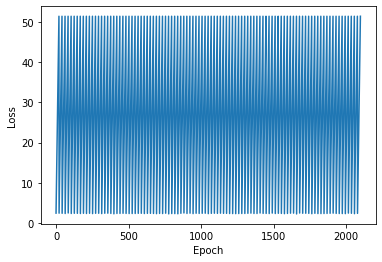

In [58]:
loss_history = []
acc_history = []
num_epochs = 100

# Train the model for a number of epochs
for epoch in range(num_epochs):
    # Initialize variables to store the average loss and accuracy for the epoch
    avg_loss = 0.0
    count = 0
    loss_sum = 0
    # Iterate through the data
    for inputs, labels in train_dataloader:
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss and the accuracy
        loss = loss_fn(outputs, labels)
        loss_sum += loss
        # Backward pass
        loss.backward()
        #update weights
        optimizer.step()

        count += 1
        # Append the loss and accuracy to the history
        loss_history.append(loss_sum.item() / len(train_dataloader))
    # Print the loss and accuracy for the epoch
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum.item() / len(train_dataloader)}")



# Plot the loss and accuracy history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

Epoch 1\n-------------------------------


NameError: ignored

In [ ]:
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape, y_batch.shape)

TypeError: ignored

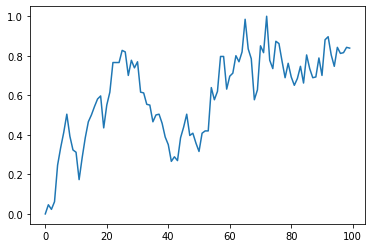

In [50]:
plt.plot(train_dataloader.dataset[1000][0])

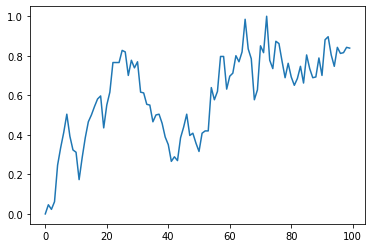

In [51]:
plt.plot(train_dataloader.dataset[1000][1])

In [ ]:
import torch

# Define the input data
input_data = torch.randn(64, 3, 32, 32)

# Create a fully connected layer
fc = torch.nn.Linear(3 * 32 * 32, 100)

# Add batch normalization to the fully connected layer
bn = torch.nn.BatchNorm1d(100)

# Define a forward pass with batch normalization
def forward_bn(x):
    x = x.view(x.size(0), -1)
    x = fc(x)
    x = bn(x)
    return x

# Add layer normalization to the fully connected layer
ln = torch.nn.LayerNorm(100)

# Define a forward pass with layer normalization
def forward_ln(x):
    x = x.view(x.size(0), -1)
    x = fc(x)
    x = ln(x)
    return x

# Apply the forward pass with batch normalization to the input data
output_bn = forward_bn(input_data)

# Apply the forward pass with layer normalization to the input data
output_ln = forward_ln(input_data)

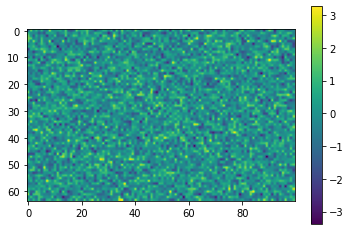

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
values = output_bn.flatten()

# Extract the dimensions of the tensor
values = output_bn.detach().numpy()

# Create a figure and a subplot
fig, ax = plt.subplots()

# Create a heatmap
im = ax.imshow(values)

# Add a colorbar
fig.colorbar(im)

# Show the plot
plt.show()

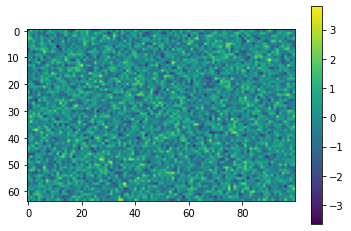

In [ ]:
values = output_bn.flatten()

# Extract the dimensions of the tensor
values = output_ln.detach().numpy()

# Create a figure and a subplot
fig, ax = plt.subplots()

# Create a heatmap
im = ax.imshow(values)

# Add a colorbar
fig.colorbar(im)

# Show the plot
plt.show()

In [ ]:
output_bn.detach().size()

torch.Size([64, 100])

In [ ]:
for X_batch, y_batch in train_dataloader:
    print(X＿batch.to(torch.float32).size())

torch.Size([64, 1440, 1])
torch.Size([41, 1440, 1])


In [ ]:
tload = DataLoader(train_set)
for X_batch, y_batch in tload:
    print(X_batch.shape, y_batch.shape)

torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
torch.Size([1, 1440, 1]) torch.Size([1, 1440, 1])
